In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.stats import norm

from astropy.table import Table

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
def num_problem(array):
    num_nan = np.sum(np.isnan(array))
    num_inf = np.sum(np.isinf(array))
    return(num_nan,num_inf)

In [4]:
def gaussian_pdf(x,params):
    mean,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [5]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [6]:
def straight_line_gaus(x,y,params):
    m,c,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((y-(m*x+c))**2/(2*sig**2))))

In [7]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [8]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [9]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [10]:
def get_fir_lum(L,q,sig):
    #given the radio luminosity of a source (in W) it will return a FIR luminosity based on a FIRC 
    #from a given q value and scatter sig
    noise = np.random.normal(0,sig,len(L))
    q = q + noise
    fir = q + np.log10(L) + np.log10(3.75E12)
    return(fir)

In [11]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir/3.75E12) - np.log10(l_rad)
    return(Q)

In [194]:
def straight_line_gaus_with_selection(x,y,params):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9,cdf_mean,cdf_sig,rad_lum_low,rad_lum_up = params
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    params_cdf = [cdf_mean,cdf_sig]
    
    bins=np.linspace(rad_lum_low,rad_lum_up,len(sf_prop)+1)
    sf_prop_bin_in = np.digitize(x,bins=bins)
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    model = (sf_prop[sf_prop_bin_in-1]*straight_line_gaus(x,y,params_sf) + (1-sf_prop[sf_prop_bin_in-1])*straight_line_gaus(x,y,params_agn))

    selection = 1-gaus_cdf(np.arange(5,15,0.1),params_cdf)
    answer = model.transpose()*selection
    return(answer.transpose())

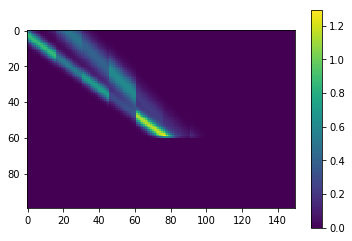

In [195]:
theta = median_params
xbin = np.arange(15,30,0.1)
ybin = np.arange(5,15,0.1)
xbin,ybin = np.meshgrid(xbin,ybin)
test = straight_line_gaus_with_selection(xbin,ybin,list(theta)+[11,0.01]+[15,30])
plt.imshow(test)
plt.colorbar()

In [190]:
print(np.sum(test[:,1:2]))
tot = 0
col = test[:,1:2]
for n,val in enumerate(test[:,1:2]):
    if n==len(col)-1:
        break
    tot = (col[n]+col[n+1])/2*0.1 + tot
print(tot)

5.2959848594820205
[0.51555449]


In [191]:
print(np.trapz(test,dx=0.1,axis=0))
print(np.trapz(np.trapz(test,dx=0.1,axis=0),dx=0.1))

[4.89622896e-01 5.15554492e-01 5.32511628e-01 5.42751437e-01
 5.48506165e-01 5.51600042e-01 5.53338255e-01 5.54578746e-01
 5.55878787e-01 5.57639134e-01 5.60210384e-01 5.63955632e-01
 5.69276241e-01 5.76609162e-01 5.86402247e-01 5.99072452e-01
 4.25747182e-01 4.54501424e-01 4.88320655e-01 5.26852844e-01
 5.69381539e-01 6.14853014e-01 6.61950184e-01 7.09205363e-01
 7.55136042e-01 7.98382954e-01 8.37829231e-01 8.72683452e-01
 9.02516865e-01 9.27253942e-01 9.47123640e-01 9.69395627e-01
 9.78927945e-01 9.85888290e-01 9.90811612e-01 9.94185109e-01
 9.96424326e-01 9.97864135e-01 9.98760956e-01 9.99302081e-01
 9.99618366e-01 9.99797448e-01 9.99895670e-01 9.99947856e-01
 9.99974715e-01 9.99988106e-01 9.99991759e-01 9.99996353e-01
 9.99998435e-01 9.99999348e-01 9.99999737e-01 9.99999897e-01
 9.99999959e-01 9.99999981e-01 9.99999982e-01 9.99999962e-01
 9.99999903e-01 9.99999754e-01 9.99999387e-01 9.99998516e-01
 9.99996502e-01 9.99996066e-01 9.99989383e-01 9.99970704e-01
 9.99918834e-01 9.997790

In [148]:
test.shape

(100, 150)

In [13]:
vla_data = Table.read('data/VLA_3GHz_counterpart_array_20170210_paper_delvecchio_et_al.fits.txt')

In [14]:
vla_data[0]

ID_VLA3,RA_VLA3,DEC_VLA3,Z_BEST,Z_TYPE,FLUX_INT_3GHz,Lradio_10cm,Lradio_21cm,L_TIR_SF,flag_herschel3,Mstar,SFR_IR,NUV_R,XRAY_AGN,MIR_AGN,SED_AGN,Radio_excess,Class
int32,float64,float64,float32,bytes17,float64,float64,float64,float64,bytes25,float64,float64,float64,int32,int32,int32,int32,bytes16
1,149.647714,2.095465,1.5457,phot,16147.04,25.839253,25.717876,11.6626,true,11.224274,45.983324,2.416443,0,0,0,1,MLAGN


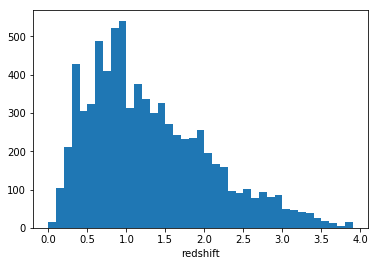

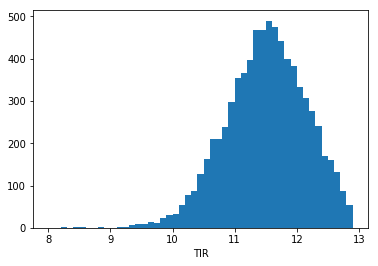

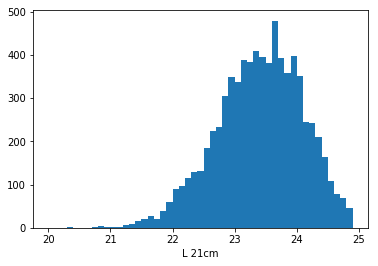

In [15]:
bins=np.arange(0,4,0.1)
plt.hist(vla_data['Z_BEST'],bins=bins)
plt.xlabel('redshift')
plt.show()

bins=np.arange(8,13,0.1)
plt.hist(vla_data['L_TIR_SF'],bins=bins)
plt.xlabel('TIR')
plt.show()

bins=np.arange(20,25,0.1)
plt.hist(vla_data['Lradio_21cm'],bins=bins)
plt.xlabel('L 21cm')
plt.show()

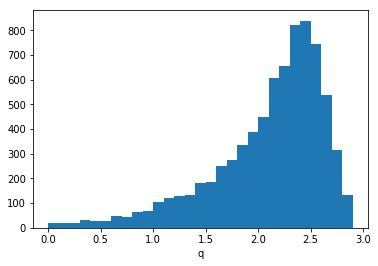

In [18]:
redshift = vla_data['Z_BEST']
mask = (redshift>0.0) & (redshift<0.5) & (vla_data['Class']!='HLAGN')
rad_lum = vla_data['Lradio_21cm']
fir_lum = vla_data['L_TIR_SF']
plot = fir_lum+26+np.log10(3.828)-12-np.log10(3.75) - rad_lum

bins=np.arange(0,3,0.1)
plt.hist(plot,bins=bins)
plt.xlabel('q')
plt.show()

In [19]:
detection = fir_lum>11

In [20]:
params = ['m_sf','c_sf','sig_sf','m_agn','c_agn','sig_agn',
         'sf_prop_0','sf_prop_1','sf_prop_2','sf_prop_3','sf_prop_4','sf_prop_5','sf_prop_6',
         'sf_prop_7','sf_prop_8','sf_prop_9']
nwalkers = 40  # number of individual chains to make
ndim     = len(params) # number of dimensions
preburns = 200  # length of "burn-in" period to be discarded
burns    = 200 # number of iterations to be used after initial burn-in.

In [19]:
PRIORS = {     'm_sf'   :  [ 0.9   ,   1.1 ] ,
               'c_sf'   :  [-12,-11],
               'sig_sf'   :  [ 0.9   ,   1.1 ] ,
               'm_agn'    :  [  0.9   ,    1.1 ] ,
               'c_agn'    :  [-13,-12],
               'sig_agn'    :  [  4   ,    6 ] ,
          'sf_prop_0'   :  [0.75,0.8],
         'sf_prop_1'    :  [  0.75   ,    0.8 ],
         'sf_prop_2'    :  [0.75   ,    0.8],
         'sf_prop_3'    :  [0.75   ,    0.8],
         'sf_prop_4'    :  [0.75   ,    0.8],
         'sf_prop_5'    :  [0.75   ,    0.8],
         'sf_prop_6'    :  [  0.8   ,    0.85 ],
         'sf_prop_7'    :  [  0.8   ,    0.85 ],
         'sf_prop_8'    :  [  0.9   ,    0.95 ],
         'sf_prop_9'    :  [  0   ,    0.01 ]}

In [24]:
PRIORS = {     'm_sf'   :  [ 0   ,   2 ] ,
               'c_sf'   :  [-20,0],
               'sig_sf'   :  [ 0   ,   2 ] ,
               'm_agn'    :  [  0   ,    2 ] ,
               'c_agn'    :  [-20,0],
               'sig_agn'    :  [  0   ,    10 ] ,
          'sf_prop_0'   :  [0,1],
         'sf_prop_1'    :  [  0   ,    1 ],
         'sf_prop_2'    :  [  0   ,    1 ],
         'sf_prop_3'    :  [  0   ,    1 ],
         'sf_prop_4'    :  [  0   ,    1 ],
         'sf_prop_5'    :  [  0   ,    1 ],
         'sf_prop_6'    :  [  0   ,    1 ],
         'sf_prop_7'    :  [  0   ,    1 ],
         'sf_prop_8'    :  [  0   ,    1 ],
         'sf_prop_9'    :  [  0   ,    1 ]}

In [220]:
def lnprior(theta,PRIORS):

    P = np.zeros(len(theta))

    for i,p in enumerate(params):
        if ( PRIORS[p][0]<= theta[i] <= PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return(-np.inf)
        #return(0.0)
    else: 
        return(0.0)
        #return(1.0)
    
def lnlike(theta,x,y):
    #return(-0.5*sum( ( y-model( x, theta  ) )**2))
    #plt.scatter(x,y)
    #plt.plot(x,model(x,theta))
    #plt.show()
    
    if len(x)==0:
        return(0)
    
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9 = theta
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    
    bins = np.linspace(18.5,28,11)
    sf_prop_bins_in = np.digitize(x,bins=bins)
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    model = sf_prop[sf_prop_bins_in-1]*straight_line_gaus(x,y,params_sf) + (1-sf_prop[sf_prop_bins_in-1])*straight_line_gaus(x,y,params_agn)
    

    lnlike = np.log(model)
    lnlike = np.sum(lnlike)
    #print('lnlike is: {}'.format(lnlike))
    return(lnlike)
    
def lnmissing(theta,x_y_mis,theta_sel,theta_rng):
    
    '''dx = 0.01
    x = np.arange(-20,20,dx)
    area = 0
    for n in range(len(x)-1):
        y1 = model(x[n],theta) * selection(x[n],theta_sel)
        y2 = model(x[n+1],theta) * selection(x[n+1],theta_sel)
        y_avg = (y1+y2)/2
        area = y_avg*dx + area
    lnmissing = area*n_missing'''
    
    rad_lum_low,rad_lum_up,fir_lum_low,fir_lum_up = theta_rng
    #for n,val in enumerate(theta_sel):
    #    theta = np.insert(theta,len(theta),val)
    theta = list(theta)+theta_sel+theta_rng[:2]
    
    xbin = np.arange(rad_lum_low,rad_lum_up,0.1)
    ybin = np.arange(fir_lum_low,fir_lum_up,0.1)
    ybin,xbin = np.meshgrid(xbin,ybin)
    model = straight_line_gaus_with_selection(xbin,ybin,theta)
    
    #this np.trapz could be doing something wrong so if there is a bug this is somewhere to check
    int_first = np.trapz(model,dx=0.1,axis=0)
    #print('integral of missing area is :{}'.format(int_first))

    x_mis_dist,_ = np.histogram(x_y_mis,bins=np.arange(rad_lum_low,rad_lum_up+0.001,0.1))
    #print('number of sources in each bin is: {}'.format(x_mis_dist))
    prob_mis = np.log(int_first)*x_mis_dist
    #print('prob of number of missing source is: {}'.format(prob_mis))
    mask = np.isnan(prob_mis)
    prob_mis[mask] = 1#-int_first[mask]
    #int_sec = np.trapz(int_first,dx=0.01)
    lnmissing = np.nansum(prob_mis)
    return(lnmissing)

def find_pdf_normalisation(theta,x,y,theta_rng):
    m_sf,c_sf,sig_sf,m_agn,c_agn,sig_agn,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9 = theta
    params_sf  = [m_sf,c_sf,sig_sf]
    params_agn = [m_agn,c_agn,sig_agn]
    sf_prop = np.array([sf_prop_0,sf_prop_1,sf_prop_2,sf_prop_3,sf_prop_4,sf_prop_5,sf_prop_6,sf_prop_7,sf_prop_8,sf_prop_9])
    rad_lum_low,rad_lum_up,fir_lum_low,fir_lum_up = theta_rng
    
    xrng = np.arange(20,30,0.1)
    yrng = np.arange(0,25,0.1)
    xbin,ybin = np.meshgrid(xrng,yrng)
    which_sf_prop = np.digitize(xrng,bins=np.arange(20,30,1))
    model_fit = sf_prop[which_sf_prop-1]*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop[which_sf_prop-1])*straight_line_gaus(xbin,ybin,params_agn)
    int_first = np.trapz(model_fit,dx=0.1,axis=0)
    model_volume = np.trapz(int_first,dx=0.1)
    print('normalisation is is: {}'.format(model_volume))
    return(model_volume)

def lnprob(theta,x,y,x_y_mis,theta_sel,theta_rng,PRIORS):
    

    #print(theta)
    lp = lnprior(theta,PRIORS)
    #print('lp is: {}'.format(lp))
    ll = lnlike(theta,x,y)
    #print('ll is: {}'.format(ll))
    lm = lnmissing(theta,x_y_mis,theta_sel,theta_rng)
    #lm=1
    #print('lm is: {}'.format(lm))

    if not np.isfinite(lp) or not np.isfinite(ll) or not np.isfinite(lm):
        return -np.inf
    else:
        #print('likelihood is: {}'.format(lp + ll + lm))
        return lp + ll + lm

In [217]:
theta_rng = [15,30,5,15]
xdata = rad_lum[detection]
ydata = fir_lum[detection]
x_y_mis = rad_lum[~detection]

theta = [np.percentile(samples[:,i],50) for i in range(ndim)]
#theta = theta_narrow_prior
print(lnmissing(theta,x_y_mis,[11,0.01],theta_rng))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[11,0.01],theta_rng,PRIORS))

print('-----------------')

theta = np.array([  0.99805629, -11.53417439,   0.98216711,   1.03575265,
       -13.29966024,   4.94075926,   0.76156029,   0.78116264,
         0.80170808,   0.80833497,   0.79669142,   0.77181826,
         0.84973138,   0.84796675,   0.92786891,   0.        ])
print(lnprior(theta,PRIORS))
print(lnmissing(theta,x_y_mis,[11,0.01],theta_rng))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[11,0.01],theta_rng,PRIORS))
print('-----------------')

theta = np.array([1,-11.2,1,1,-12.9,5,0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,0.0])
print(lnprior(theta,PRIORS))
print(lnmissing(theta,x_y_mis,[11,0.01],theta_rng))
print(lnlike(theta,rad_lum[detection],fir_lum[detection]))
print(lnprob(theta,rad_lum[detection],fir_lum[detection],x_y_mis,[11,0.01],theta_rng,PRIORS))

-inf
-4404.726311718927
ll is: -4404.726311718927
lm is: -inf
-inf
-----------------
0.0
-24325.712682746467
-7608.715800484205
ll is: -7608.715800484205
lm is: -24325.712682746467
-31934.428483230673
-----------------
0.0
-23767.100419181457
-8647.558697856222
ll is: -8647.558697856222
lm is: -23767.100419181457
-32414.659117037678


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply


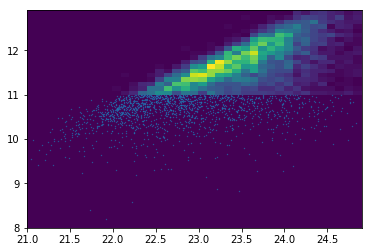

In [31]:
xdata = rad_lum[detection]
ydata = fir_lum[detection]

x_y_mis = rad_lum[~detection] 
plt.hist2d(xdata,ydata,bins=[np.arange(21,25,0.1),np.arange(8,13,0.1)])
plt.scatter(x_y_mis,fir_lum[~detection],s=0.1)

#plt.ylim(8,13)
plt.show()

In [210]:
x_y_mis

<MaskedColumn name='Lradio_21cm' dtype='float64' length=0>

In [229]:
xdata = rad_lum[detection]
ydata = fir_lum[detection]
x_y_mis = rad_lum[~detection]
#theta_rng is the parametrs that control what luminosity range the code runs in in order to keep the PDF
#across the same area of paramter space
#it is structured [radio luminosity lower bound, radio luminosity upper bound,FIR luminosity lower bound, FIR luminosity upper bound]
theta_rng = [18.5,28,5,15]

'''start_val = []
for n in range(nwalkers) :
    sig = abs(theta_true/50)
    noise = np.random.normal(0,sig,len(sig))
    temp = theta_true + noise
    for i,p in enumerate(params):
        if ( PRIORS[p][0]<= temp[i] <= PRIORS[p][1] ):()
        else:
            temp[i] = PRIORS[p][1]
    start_val.append(temp)



pos = np.zeros((nwalkers,ndim))  + start_val
#pos = np.zeros((nwalkers,ndim))  + theta_true
#start_pos = np.zeros((nwalkers,ndim))
print(pos)'''

pos = np.zeros((nwalkers,ndim))
for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]


sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[xdata,ydata,x_y_mis,[11,0.01],theta_rng,PRIORS] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]

MCMC start 


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


MCMC end, Time taken:  96.08294534683228


In [36]:
probs = []
for n,chain in enumerate(sampler.chain[:,:,:]):

    prob_chain = []
    for m,var in enumerate(chain):

        prob_chain = prob_chain + [lnprob(var,xdata,ydata,x_y_mis,[8.5,0.01])]
    probs.append(prob_chain)
    #lnprob(samples,xdata,ydata,x_y_mis,[8.5,0.01])


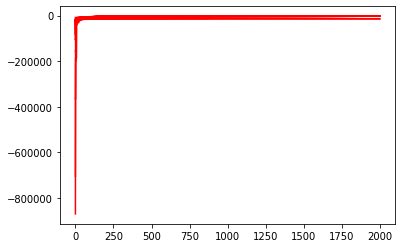

In [37]:
np.array(probs[0]).shape
for chain in probs:
    plt.plot(chain,c='red')
plt.show()

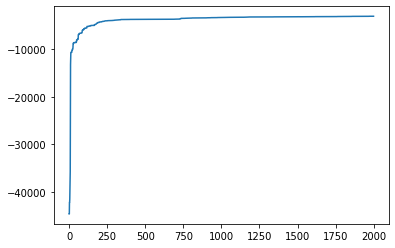

In [38]:
plt.plot(probs[0])

In [39]:
sampler.chain[1,:,:][0]

array([  0.28320325, -12.98533317,   0.54144235,   0.41108016,
        -1.16111895,   4.07123026,   0.87432304,   0.3688306 ,
         0.2356229 ,   0.3353814 ,   0.47435325,   0.70298742,
         0.96863298,   0.13958024,   0.5483008 ,   0.59359047])

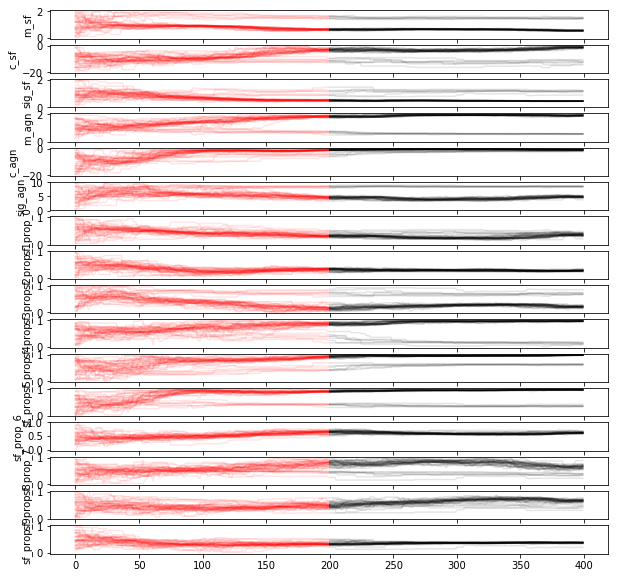

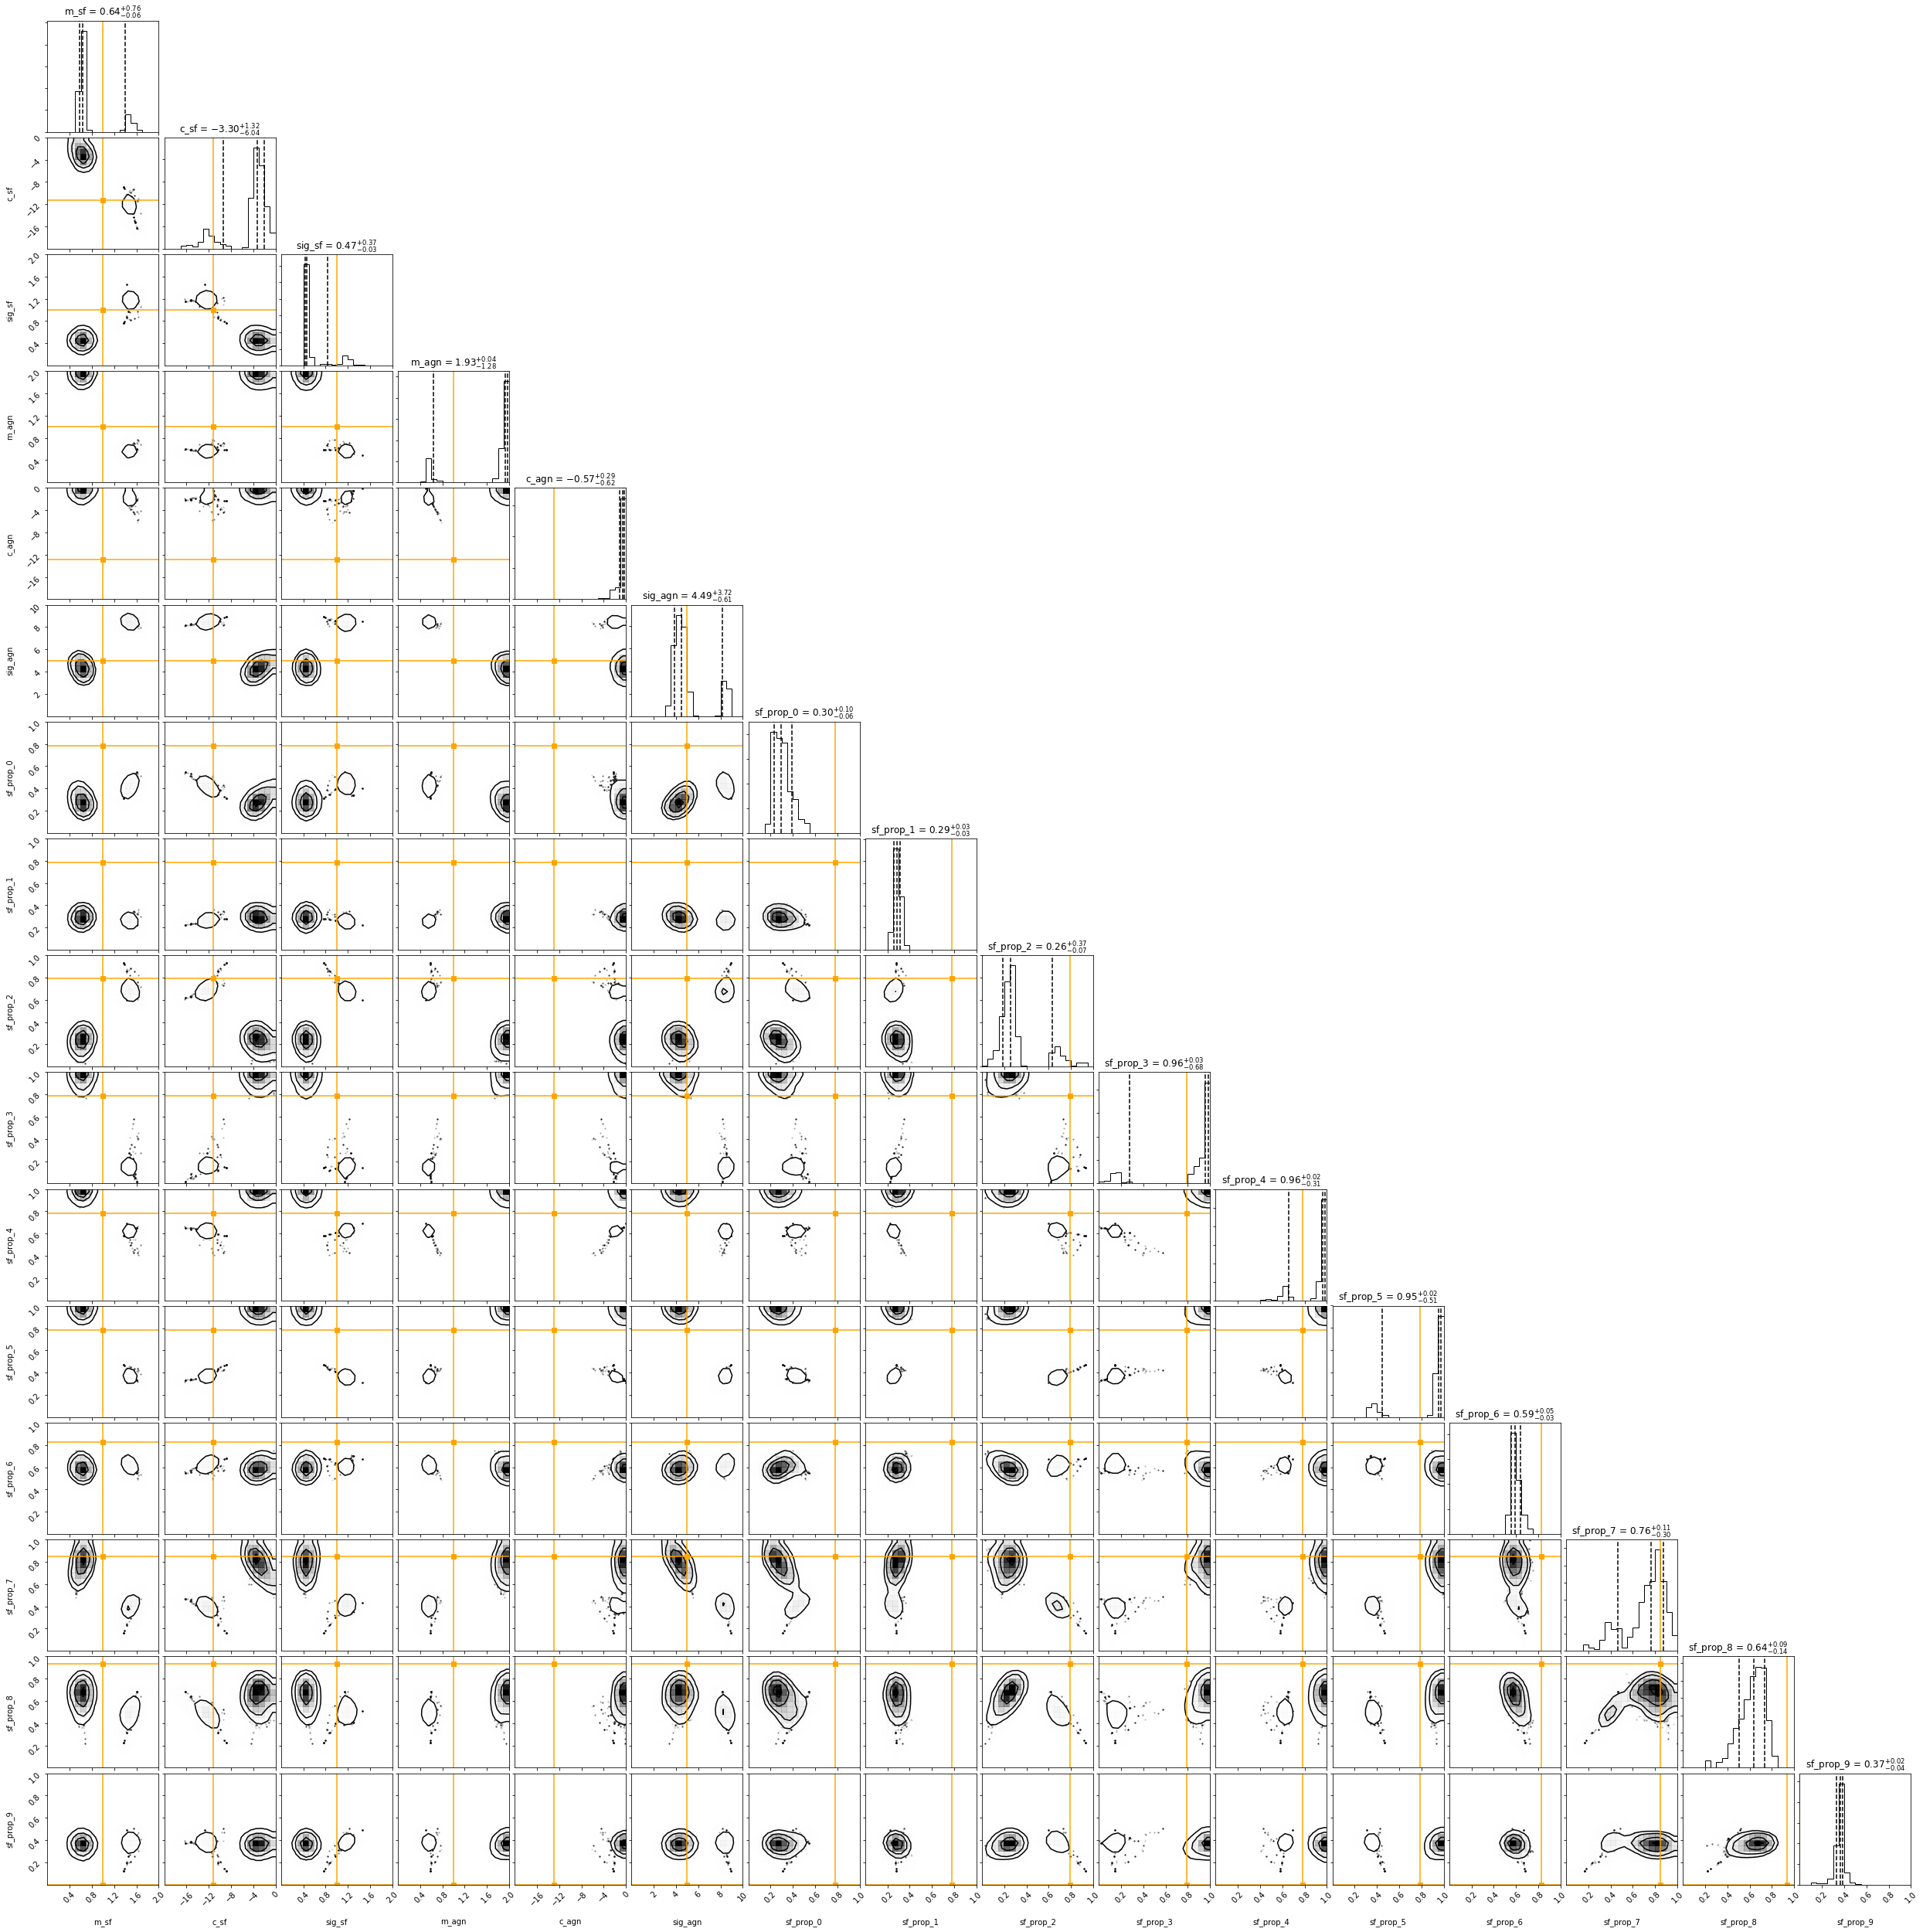

In [230]:
theta_true = np.array([1,-11.2,1,1,-12.9,5,0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,        0])

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )

import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])

In [51]:
plt.plot(median_params[6:],c='red')
plt

NameError: name 'median_params' is not defined

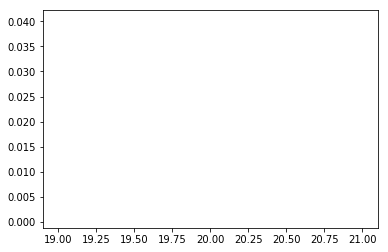

ValueError: x and y must have same first dimension, but have shapes (24,) and (23, 19)

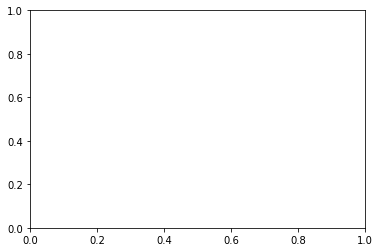

In [43]:
median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
#median_params = [1,-12,1,1,-12,5,10/13]
x = np.linspace(20,25,10)
y = np.arange(20,25,10)
xbin,ybin = np.meshgrid(x,y)

params_sf = median_params[:3]
params_agn = median_params[3:6]
sf_prop = np.array(median_params[6:])
fitted_data = sf_prop*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop)*straight_line_gaus(xbin,ybin,params_agn)


plt.plot(ybin,fitted_data)
plt.show()

x = np.arange(20,25,0.25)
y = np.arange(8,14,0.25)
binned_data,_,_ = np.histogram2d(rad_lum,fir_lum,bins=[x,y])
#binned_data = np.sum(binned_data,axis=0)
y = np.arange(0.5,24.5,1)
plt.plot(y,binned_data.transpose())
plt.show()

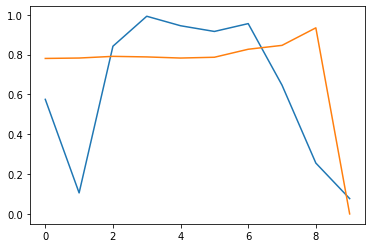

In [55]:
x = get_center(np.arange(20,30,1))
sf_prop = np.array(median_params[6:])
plt.plot(sf_prop)
plt.plot(theta_true[6:])

In [ ]:
median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
median_params = [1,-12,1,1,-12,5,10/13]
x = np.arange(20,30,0.5)
y = np.arange(0,25,0.5)
xbin,ybin = np.meshgrid(x,y)

params_sf = median_params[:3]
params_agn = median_params[3:6]
sf_prop = median_params[-1]
fitted_data = sf_prop*straight_line_gaus(xbin,ybin,params_sf) + (1-sf_prop)*straight_line_gaus(xbin,ybin,params_agn)


plt.plot(ybin,normalise_data.transpose())
plt.show()

plt.plot(ybin,fitted_data)
plt.show()

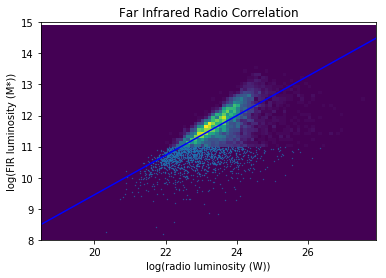

In [238]:
xdata = rad_lum[detection]
ydata = fir_lum[detection]

x_y_mis = rad_lum[~detection] 
plt.hist2d(xdata,ydata,bins=[np.arange(18.5,28,0.1),np.arange(8,15,0.1)])
plt.scatter(x_y_mis,fir_lum[~detection],s=0.1)

x = np.arange(18.5,28,0.1)
y = median_params[0]*x + median_params[1]
plt.plot(x,y,c='blue')

y = median_params[3]*x + median_params[4]
plt.plot(x,y,c='red')


plt.ylim(8,15)
plt.xlabel('log(radio luminosity (W))')
plt.ylabel('log(FIR luminosity (M*))')
plt.title('Far Infrared Radio Correlation')
plt.show()

lnlike is: -1.5416907290862678
lnmissing is: -1.5416907290862678
number of detected sources is: 1 
number of missed sources is: 1


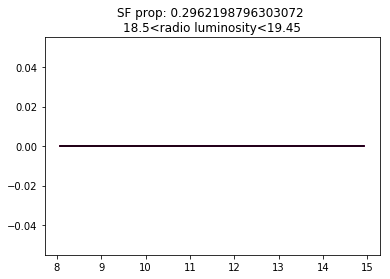

---------------------
lnlike is: -3.453912233566219
lnmissing is: -3.453912233566219
number of detected sources is: 2 
number of missed sources is: 2


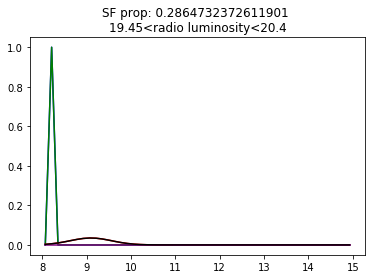

---------------------
lnlike is: -41.56590864969593
lnmissing is: -41.56590864969593
number of detected sources is: 22 
number of missed sources is: 22


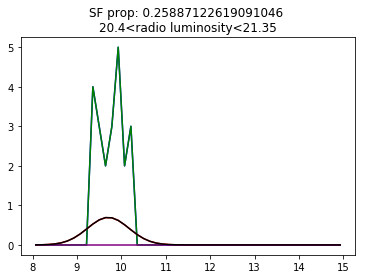

---------------------
lnlike is: -983.5265776040724
lnmissing is: -977.242199650899
number of detected sources is: 489 
number of missed sources is: 472


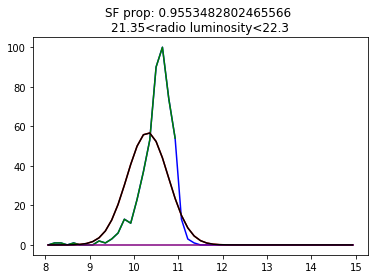

---------------------
lnlike is: -2090.4336015645968
lnmissing is: -1573.6694456096875
number of detected sources is: 2476 
number of missed sources is: 703


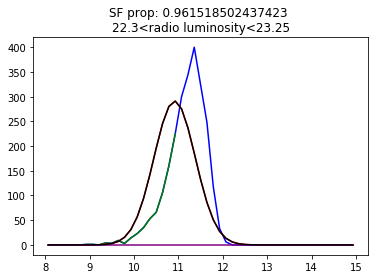

---------------------
lnlike is: -2471.283641597907
lnmissing is: -817.8890671642276
number of detected sources is: 3600 
number of missed sources is: 330


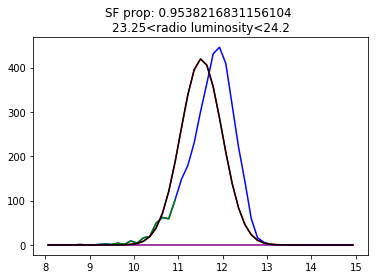

---------------------
lnlike is: -1502.1439612864274
lnmissing is: -185.45083485225507
number of detected sources is: 994 
number of missed sources is: 68


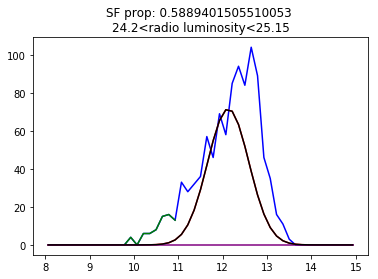

---------------------
lnlike is: -369.7735519366357
lnmissing is: -54.53371707423618
number of detected sources is: 123 
number of missed sources is: 18


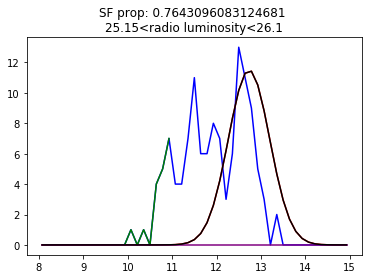

---------------------
lnlike is: -158.40227171829818
lnmissing is: -3.372396623709481
number of detected sources is: 21 
number of missed sources is: 1


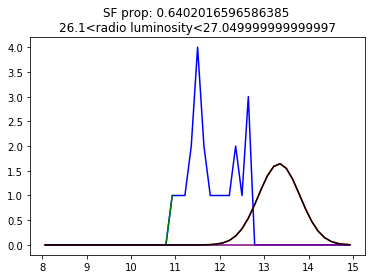

---------------------
lnlike is: -7.97634461062383
lnmissing is: 0.0
number of detected sources is: 1 
number of missed sources is: 0


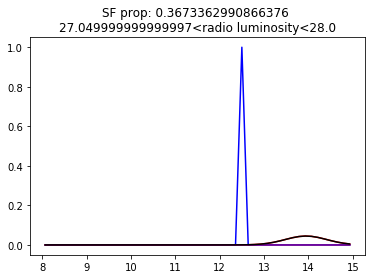

---------------------


In [232]:
theta = median_params
xdata = rad_lum
ydata = fir_lum
data,rad_edge,fir_edge = np.histogram2d(xdata,ydata,bins=[np.linspace(18.5,28,11),np.linspace(8,15,50)])
theta_rng = [15,30,5,15]

bins = np.linspace(8,15,50)
xpoint = get_center(bins)
for n,column in enumerate(data):

    mask = (rad_lum>rad_edge[n]) & (rad_lum<rad_edge[n+1]) 
    xdata = rad_lum[mask]
    y_data = fir_lum[mask]
    x_y_mis = rad_lum[mask&~detection]
    print('lnlike is: {}'.format(lnprob(theta,rad_lum[detection&mask],fir_lum[detection&mask],x_y_mis,[11,0.01],theta_rng,PRIORS)))
    print('lnmissing is: {}'.format(lnmissing(theta,x_y_mis,[11,0.01],theta_rng)))
    print('number of detected sources is: {} \nnumber of missed sources is: {}'.format(len(xdata),len(x_y_mis)))
    #plt.plot(xpoint,column/np.sum(column))
    plt.plot(xpoint,column,c='blue')
    mask = xpoint<11
    plt.plot(xpoint[mask],column[mask],c='green')
    
    mean = rad_edge[n]*theta[0] + theta[1]
    sig = theta[2]
    ysf = gaussian_pdf(xpoint,[mean,sig])/7*theta[6+n]*np.sum(column)
    plt.plot(xpoint,ysf,c='red')
    
    mean = rad_edge[n]*theta[3] + theta[4]
    sig = theta[5]
    yagn = gaussian_pdf(xpoint,[mean,sig])/7*(1-theta[6+n])*np.sum(column)
    plt.plot(xpoint,yagn,c='purple')
    
    plt.plot(xpoint,yagn+ysf,c='black')
    
    plt.title('SF prop: {} \n{}<radio luminosity<{}'.format(theta[n+6],rad_edge[n],rad_edge[n+1]))
    plt.show()
    print('---------------------')

In [99]:
theta = median_params
mask = (rad_lum>23) & (rad_lum<24) & (fir_lum>11)
mask_det = (rad_lum>21) & (rad_lum<21.5) & (fir_lum<11)
xdata = rad_lum[mask]
ydata = fir_lum[mask]
dat_mis = rad_lum[mask_det]

print(lnprior(theta))
print(lnlike(theta,xdata,ydata))
print(lnprob(theta,xdata,ydata,dat_mis,[11,0.01]))

0.0
lnlike is: -1309.2454333835408
-1309.24543338
lnlike is: -1309.2454333835408
-1334.91333067


lnlike is: -inf


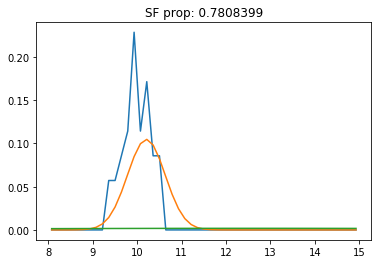

---------------------
lnlike is: -inf


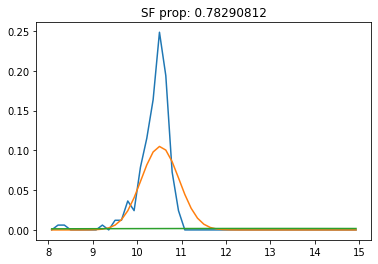

---------------------
lnlike is: -45.392726464025216


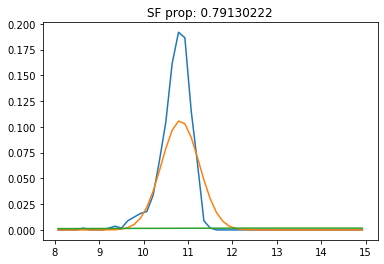

---------------------
lnlike is: -337.12712841460757


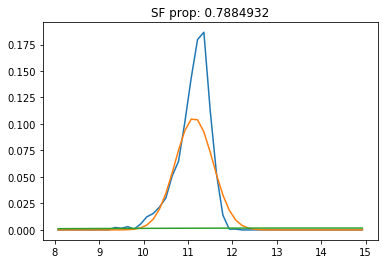

---------------------
lnlike is: -784.5595009878886


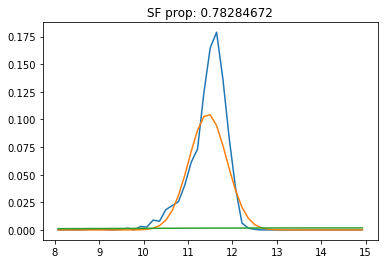

---------------------
lnlike is: -1221.0626717362288


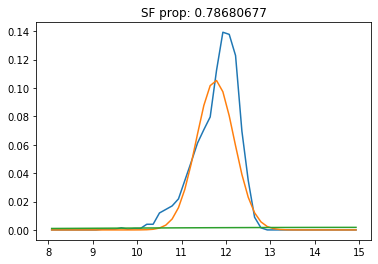

---------------------
lnlike is: -1081.6702466216934


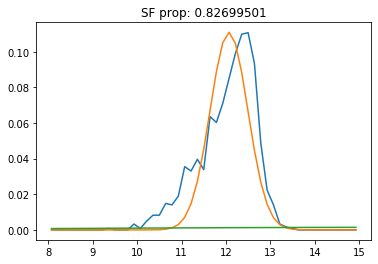

---------------------
lnlike is: -434.14179755961146


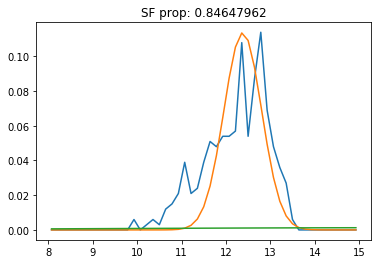

---------------------
lnlike is: -207.3279439779432


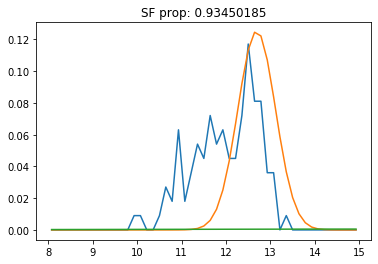

---------------------
lnlike is: -127.30940704256102


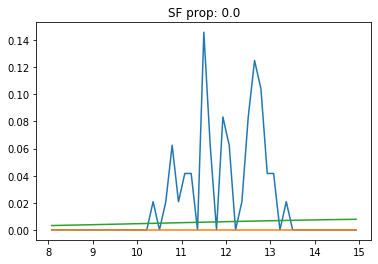

---------------------


In [110]:
theta = np.array([theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],0.7808399 , 0.78290812, 0.79130222, 0.7884932 , 0.78284672,
       0.78680677, 0.82699501, 0.84647962, 0.93450185,0.0])
xdata = rad_lum
ydata = fir_lum
data,rad_edge,fir_edge = np.histogram2d(xdata,ydata,bins=[np.linspace(21,26,11),np.linspace(8,15,50)])

bins = np.linspace(8,15,50)
xpoint = get_center(bins)
for n,column in enumerate(data):

    mask = (rad_lum>rad_edge[n]) & (rad_lum<rad_edge[n+1]) 
    xdata = rad_lum[mask]
    y_data = fir_lum[mask]
    x_y_mis = rad_lum[mask&~detection]
    print('lnlike is: {}'.format(lnprob(theta,rad_lum[detection&mask],fir_lum[detection&mask],x_y_mis,[11,0.01])))
    
    plt.plot(xpoint,column/np.sum(column))
    
    mean = rad_edge[n]*theta[0] + theta[1]
    sig = theta[2]
    ysf = gaussian_pdf(xpoint,[mean,sig])/7*theta[6+n]
    plt.plot(xpoint,ysf)
    
    mean = rad_edge[n]*theta[3] + theta[4]
    sig = theta[5]
    yagn = gaussian_pdf(xpoint,[mean,sig])/7*(1-theta[6+n])
    plt.plot(xpoint,yagn)
    
    plt.title('SF prop: {}'.format(theta[n+6]))
    plt.show()
    print('---------------------')